In [2]:
import preprocessing as pp
import os
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm

train_df_X, train_df_Y, test_df_X, test_df_Y  = pp.preprocessing_data("data/regularite-mensuelle-tgv-aqst.csv")


train_df_X.head()

c:\Users\joaop\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,duree_moyenne,nb_train_prevu,nb_train_depart_retard,nb_train_retard_arrivee,gare_depart_AIX EN PROVENCE TGV,gare_depart_ANGERS SAINT LAUD,gare_depart_ANGOULEME,gare_depart_ANNECY,gare_depart_ARRAS,gare_depart_AVIGNON TGV,...,gare_arrivee_STUTTGART,gare_arrivee_TOULON,gare_arrivee_TOULOUSE MATABIAU,gare_arrivee_TOURCOING,gare_arrivee_TOURS,gare_arrivee_VALENCE ALIXAN TGV,gare_arrivee_VANNES,gare_arrivee_ZURICH,service_International,service_National
0,0.150365,-0.242791,-0.746125,-0.723776,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.988367,-0.933220,-0.768254,-0.488304,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.081703,1.069024,2.407253,3.918386,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.971104,0.021873,-0.491642,-0.286471,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,-1.325854,1.074777,-0.347804,0.487223,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Forward Subset Selection

In [29]:
def processSubset(feature_set):
    # Fit OLS (Ordinary Least Squares) model on feature_set and calculate RSS
    model = sm.OLS(train_df_Y,train_df_X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(test_df_X[list(feature_set)]) - test_df_Y.values) ** 2).sum().mean()
    return {"model":regr, "RSS":RSS}

def forward(features):

    # Pull out features we still need to process
    remaining_features = [d for d in train_df_X.columns if d not in features]
    tic = time.time()

    results = []

    for d in remaining_features:
        results.append(processSubset(features+[d]))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the lowest RSS

    best_model = models.loc[models['RSS'].argmin()]

    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")

    # Return the best model, along with some other useful information about the model
    return best_model

In [4]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
features = []

for i in range(1,len(train_df_X.columns)+1):
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")


Processed  124 models on 1 features in 0.3324615955352783 seconds.
Processed  123 models on 2 features in 0.3214559555053711 seconds.
Processed  122 models on 3 features in 0.3109707832336426 seconds.
Processed  121 models on 4 features in 0.33440494537353516 seconds.
Processed  120 models on 5 features in 0.36495161056518555 seconds.
Processed  119 models on 6 features in 0.4998154640197754 seconds.
Processed  118 models on 7 features in 0.5909016132354736 seconds.
Processed  117 models on 8 features in 0.6026959419250488 seconds.
Processed  116 models on 9 features in 0.6108086109161377 seconds.
Processed  115 models on 10 features in 0.7867934703826904 seconds.
Processed  114 models on 11 features in 0.9989528656005859 seconds.
Processed  113 models on 12 features in 0.8368940353393555 seconds.
Processed  112 models on 13 features in 1.2146170139312744 seconds.
Processed  111 models on 14 features in 2.427320718765259 seconds.
Processed  110 models on 15 features in 2.74441981315612

Text(0, 0.5, 'RSS')

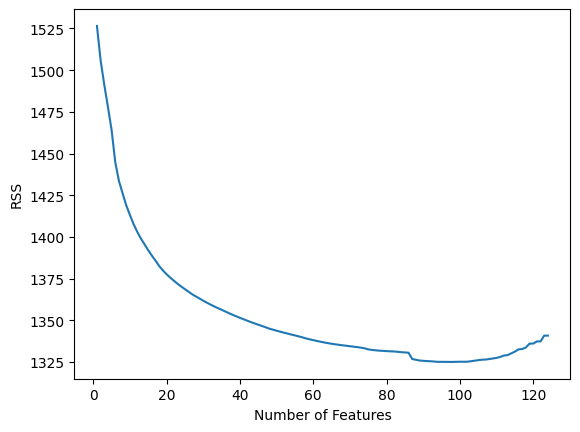

In [60]:
import matplotlib.pyplot as plt

# models_fwd.head()
plt.plot(models_fwd['RSS'])
plt.xlabel('Number of Features')
plt.ylabel('RSS')

In [61]:
# Feature added at each step
a = [model.model.exog_names[-1] for model in models_fwd["model"]]
# [models_fwd["model"][i].model.exog_names[-1] for i in models_fwd["model"]]

In [68]:
# Melhor Modelo

best_model = models_fwd[models_fwd['RSS'] == models_fwd['RSS'].min()]
best_model

,RSS,model
97,1325.058771,<statsmodels.regression.linear_model.Regressio...


In [80]:
best_model_columns = [model.model.exog_names for model in models_fwd["model"]][96]
best_model_columns

['duree_moyenne',
 'gare_depart_PARIS LYON',
 'service_International',
 'gare_arrivee_PARIS MONTPARNASSE',
 'nb_train_retard_arrivee',
 'nb_train_prevu',
 'nb_train_depart_retard',
 'gare_arrivee_PARIS NORD',
 'gare_depart_BARCELONA',
 'gare_depart_PARIS EST',
 'service_National',
 'gare_depart_PARIS MONTPARNASSE',
 'gare_depart_LYON PART DIEU',
 'gare_depart_QUIMPER',
 'gare_arrivee_PARIS EST',
 'gare_depart_ITALIE',
 'gare_depart_MARNE LA VALLEE',
 'gare_depart_LILLE',
 'gare_depart_LE CREUSOT MONTCEAU MONTCHANIN',
 'gare_arrivee_GENEVE',
 'gare_depart_TOURS',
 'gare_arrivee_TOURCOING',
 'gare_depart_MADRID',
 'gare_arrivee_BARCELONA',
 'gare_depart_ANNECY',
 'gare_depart_NIMES',
 'gare_depart_VALENCE ALIXAN TGV',
 'gare_depart_CHAMBERY CHALLES LES EAUX',
 'gare_depart_PERPIGNAN',
 'gare_depart_MACON LOCHE',
 'gare_arrivee_TOURS',
 'gare_arrivee_DOUAI',
 'gare_arrivee_ANGOULEME',
 'gare_arrivee_LAVAL',
 'gare_arrivee_ST MALO',
 'gare_arrivee_ST PIERRE DES CORPS',
 'gare_depart_BORDEA

Backward Subset Selection

In [9]:
import itertools

def backward(features):

    tic = time.time()

    results = []

    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")

    # Return the best model, along with some other useful information about the model
    return best_model

In [10]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(train_df_X.columns)))

tic = time.time()
features = train_df_X.columns

while(len(features) > 1):
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  124 models on 123 features in 24.155749559402466 seconds.
Processed  123 models on 122 features in 25.13895058631897 seconds.
Processed  122 models on 121 features in 22.01672101020813 seconds.
Processed  121 models on 120 features in 41.655749797821045 seconds.


KeyboardInterrupt: 

Text(0, 0.5, 'RSS')

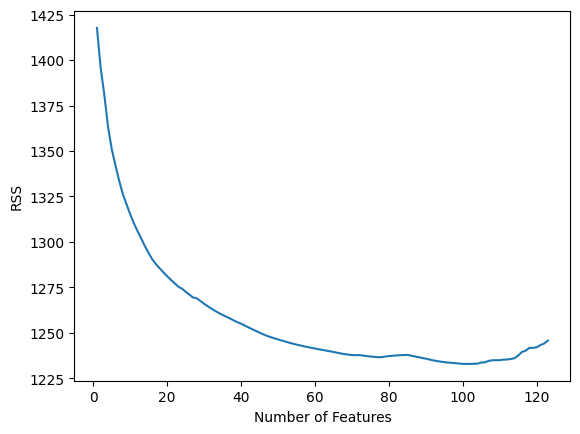

In [ ]:
import matplotlib.pyplot as plt

# models_fwd.head()
plt.plot(models_bwd['RSS'])
plt.xlabel('Number of Features')
plt.ylabel('RSS')

In [ ]:
best_model_2 = models_bwd[models_bwd['RSS'] == models_bwd['RSS'].min()]
best_model_2

,RSS,model
102,1232.901279,<statsmodels.regression.linear_model.Regressio...


Comparison of features in the models

In [ ]:
# TBD

In [11]:
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns
#Make Plotly figure
# !pip install chart_studio
import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go

In [26]:
pca = PCA()
X_reduced_train = pca.fit_transform(train_df_X)

In [27]:
pd.DataFrame(pca.components_.T).loc[:]


,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,-0.357149,0.881476,0.147680,-0.147735,-0.133816,-0.096454,0.055653,-0.008277,0.032293,0.000098,...,0.007559,0.008763,0.001611,-0.024075,-0.001869,0.009234,-1.787735e-19,-7.604109e-17,0.000000e+00,-0.000000e+00
1,0.538518,0.066676,0.438336,-0.640463,0.094170,0.194690,0.005511,0.164730,0.116694,-0.005765,...,-0.033944,0.009286,-0.006668,0.022122,0.000692,-0.011200,-3.463156e-17,-9.539736e-17,6.389290e-17,-2.387206e-17
2,0.520649,0.299760,-0.739527,-0.131675,0.079325,-0.222192,-0.000814,-0.091640,-0.039073,0.007815,...,-0.003813,0.002489,0.001498,0.004181,0.000824,-0.002018,2.271826e-17,-5.421561e-18,-1.310583e-17,-1.682586e-17
3,0.541133,0.265398,0.371869,0.683589,-0.054272,0.028459,0.000852,-0.117867,-0.057765,0.005842,...,0.011919,-0.003230,0.000879,-0.002621,0.001385,0.001235,-3.000536e-17,4.888418e-17,-3.754273e-18,1.097783e-17
4,0.003800,0.008042,-0.013611,-0.018375,-0.010447,0.020390,-0.028678,0.006884,-0.006700,0.001510,...,-0.084992,0.010923,0.041776,-0.077075,-0.081183,0.022663,4.295199e-02,-1.435894e-03,1.272109e-01,-1.423225e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.000497,-0.004552,0.008734,-0.002940,0.019213,-0.017897,-0.029639,-0.004463,-0.014200,0.000365,...,-0.049861,0.033158,-0.044910,-0.076636,0.074129,0.047014,2.593792e-02,-1.149100e-02,-1.349424e-02,-1.313210e-01
120,-0.000743,-0.004202,0.002999,-0.003328,-0.015186,0.002076,0.025982,-0.041301,-0.035897,0.001119,...,0.015979,0.047988,0.127634,0.077289,-0.046831,-0.134632,2.593792e-02,-1.149100e-02,-1.349424e-02,-1.313210e-01
121,-0.004327,0.004198,0.002694,0.005248,0.047087,0.000857,0.003112,-0.002366,-0.020588,0.000108,...,-0.022079,0.008901,-0.048651,-0.075261,0.085665,-0.023145,1.910664e-01,-1.243709e-01,-1.307392e-01,-4.729035e-03
122,-0.071874,0.111819,-0.064683,0.091626,0.517276,0.308208,0.249329,0.043294,-0.032586,-0.000107,...,-0.031180,0.009800,-0.002344,0.024841,-0.003249,0.023064,2.487479e-01,6.722727e-01,-4.382159e-02,-4.121711e-02


(-1.0, 128.1)

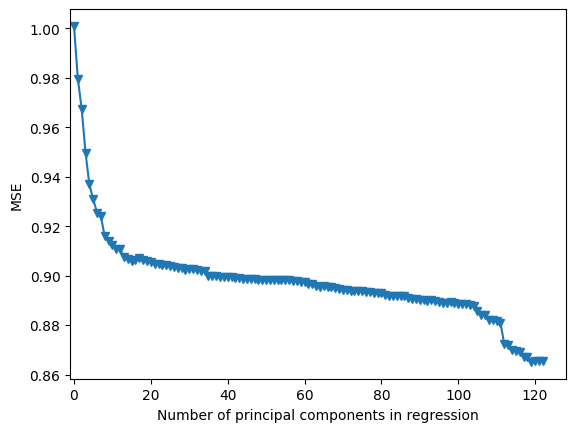

In [30]:
n = len(X_reduced_train)


# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

for i in np.arange(1, 124):
    temp_score = []
    for column_name in train_df_Y.columns:
        y_train_column = train_df_Y[column_name]
        score_col = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train_column.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
        temp_score.append(score_col)
    score_avg = np.mean(temp_score)   
    mse.append(score_avg)

plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1)


In [ ]:
print("Variability explained by each Principal Component:\n")
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

Variability explained by each Principal Component:

[42.68 56.09 63.59 67.93 71.11 74.01 76.44 78.58 80.   80.97 81.91 82.77
 83.59 84.28 84.92 85.54 85.95 86.35 86.73 87.07 87.4  87.71 87.99 88.26
 88.52 88.77 88.95 89.11 89.26 89.41 89.56 89.71 89.86 90.   90.14 90.28
 90.42 90.56 90.7  90.84 90.98 91.12 91.26 91.4  91.54 91.68 91.82 91.96
 92.1  92.24 92.38 92.52 92.66 92.8  92.94 93.08 93.22 93.36 93.5  93.63
 93.76 93.89 94.02 94.15 94.28 94.41 94.54 94.67 94.8  94.93 95.06 95.19
 95.32 95.45 95.58 95.71 95.84 95.97 96.1  96.23 96.36 96.49 96.62 96.75
 96.88 97.01 97.14 97.27 97.4  97.52 97.64 97.76 97.88 98.   98.12 98.24
 98.36 98.48 98.6  98.72 98.84 98.96 99.08 99.2  99.31 99.42 99.52 99.61
 99.68 99.75 99.81 99.86 99.9  99.92 99.94 99.96 99.97 99.98 99.98 99.98
 99.98 99.98 99.98 99.98]


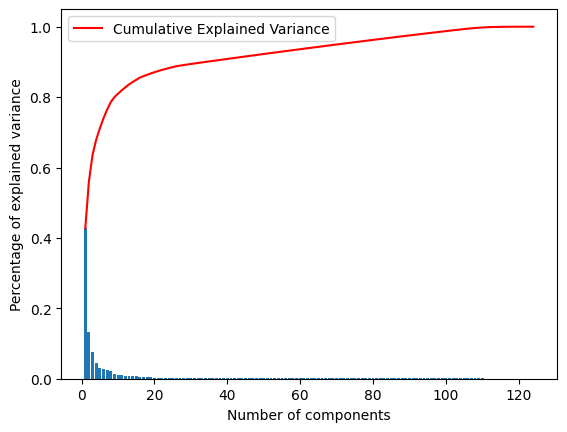

In [ ]:
# Explained variance plot
plt.bar(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ )
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_ ),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

PCA for dummy variables only

In [ ]:
pca_dummy = PCA()
train_df_X_dummy = train_df_X.drop(columns=[i for i in train_df_X.columns if i[:4]!='gare'])
X_train_pca_dummy = pca_dummy.fit_transform(train_df_X_dummy)
pd.DataFrame(pca_dummy.components_.T).loc[:]


,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,0.030121,-0.023699,-0.000528,-0.015291,-0.004507,0.000385,0.000099,-0.005652,0.000464,0.000923,...,-0.022478,-0.049057,0.054716,0.005211,-0.081684,-0.077187,-0.075126,-0.005870,-0.130151,0.003135
1,-0.000134,0.027699,0.047282,-0.031318,0.002413,-0.001871,-0.000598,0.001530,-0.004193,0.003678,...,-0.036367,-0.020854,0.023129,0.060311,0.159209,0.038157,0.076136,-0.087925,-0.130151,0.003135
2,-0.000134,0.027699,0.047282,-0.031318,0.002413,-0.001871,-0.000598,0.001530,-0.004193,0.003678,...,-0.036367,-0.020854,0.023129,0.060311,0.159209,0.038157,0.076136,-0.087925,-0.130151,0.003135
3,0.026442,-0.020781,-0.000462,-0.013328,-0.003902,0.000333,0.000085,-0.004869,0.000398,0.000790,...,-0.024700,-0.050661,0.055745,0.005298,-0.082758,-0.078105,-0.075484,-0.005887,-0.130151,0.003135
4,-0.000050,0.005889,0.000324,0.025982,-0.004367,0.002093,0.000386,-0.035995,0.146290,-0.055066,...,-0.042822,-0.118035,-0.356446,-0.289416,0.039669,0.079965,-0.070895,-0.008959,-0.130151,0.003135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.001372,0.011995,0.003564,0.056779,0.044007,0.080531,-0.001185,0.137844,0.068878,0.132933,...,-0.165621,0.188107,-0.000209,-0.090076,-0.037574,0.009365,0.002724,0.055849,-0.003135,-0.130151
114,-0.000096,0.022809,-0.036068,-0.023355,0.001729,0.001326,0.000250,-0.000078,-0.003279,0.002960,...,0.084769,-0.005448,-0.011638,0.046174,-0.086976,0.134619,-0.048089,-0.120906,-0.003135,-0.130151
115,-0.028784,-0.023013,-0.000556,-0.014369,-0.003340,-0.000926,0.000066,0.006900,0.001118,-0.001144,...,0.022495,-0.056543,-0.054361,0.021902,0.000278,-0.102474,0.079453,0.025315,-0.003135,-0.130151
116,-0.000115,0.027379,-0.043379,-0.028258,0.002111,0.001620,0.000306,-0.000095,-0.004054,0.003670,...,0.073500,-0.005195,-0.011324,0.045070,-0.085329,0.132310,-0.047757,-0.120394,-0.003135,-0.130151


In [31]:
print("Variability explained by each Principal Component:\n")
print(np.cumsum(np.round(pca_dummy.explained_variance_ratio_, decimals=4)*100))

Variability explained by each Principal Component:

[ 11.1   20.26  27.77  32.65  35.94  39.13  42.28  44.97  47.31  49.51
  51.6   52.97  54.29  55.6   56.71  57.79  58.86  59.78  60.68  61.52
  62.33  62.92  63.45  63.95  64.44  64.93  65.41  65.89  66.36  66.83
  67.3   67.77  68.23  68.69  69.15  69.61  70.07  70.53  70.99  71.45
  71.91  72.37  72.83  73.28  73.73  74.18  74.63  75.08  75.53  75.98
  76.42  76.86  77.3   77.74  78.18  78.62  79.06  79.5   79.94  80.38
  80.81  81.24  81.67  82.1   82.53  82.96  83.39  83.82  84.25  84.68
  85.11  85.54  85.97  86.4   86.83  87.26  87.68  88.1   88.52  88.94
  89.36  89.78  90.19  90.6   91.01  91.42  91.83  92.24  92.65  93.06
  93.46  93.86  94.26  94.66  95.06  95.46  95.85  96.24  96.63  97.02
  97.4   97.78  98.16  98.53  98.81  99.08  99.31  99.53  99.72  99.81
  99.87  99.92  99.96 100.   100.02 100.03 100.03 100.03]
